# Team Salary Analysis Notebook

In this notebook we will scrape salary data and use it for analysis, and visualizations. We will begin by importing a few libraries we will use.

In [227]:
# you may need to install these first

#used for scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re # used to filter text when scraping - not for the scraping function directly

# used for plotting
import collections
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Scraping Functions

Next, are our scraping functions: getSalariesUSAT, which scrapes salary data from USA Today (given a url, and list of teams which to scrape), and getSalariesSpotrac, which scrapes from Spotrac. We scrape from USA Today for earlier seasons, and use Spotrac for recent seasons due to data availability purposes.

In [96]:
# get salaries from USA Today
def getSalariesUSAT(year, team_list):
    
        url_head = "http://web.archive.org/web/20120426231626/http://content.usatoday.com:80/sportsdata/football/nfl/"
        url_end = "/salaries/"
                
        total_sal = 0
        salary_list = {}
        salary_breakdown = {}

        for team in team_list:
                
                html = urlopen(url_head + team + url_end + str(year))
                soup = BeautifulSoup(html)

                salary_table = soup.find(lambda tag: tag.name=='table' and 
                        tag.has_attr('id') and tag['id']=="team-salaries")

                rows = salary_table.findAll(lambda tag: tag.name == "tr")

                for row in rows[1:]:

                        # get the player's position
                        position = row.find(class_ = "c").string

                        # move two columns back in the row from position to find cap hit
                        cap = row.find(class_ = "c").findPrevious("td").findPrevious("td").string

                        # if cap is empty, just let it be 0
                        if not cap:
                            cap = "0"
                            
                        # remove commas and dollar signs
                        cap_clean = re.sub('[^0-9]','', cap)

                        # convert cap hit from string to integer
                        cap_clean = int(cap_clean) 

                        if position in salary_breakdown:

                                salary_list[position].append(cap_clean)
                                salary_breakdown[position] += cap_clean

                        else:

                                salary_list[position] = [cap_clean]
                                salary_breakdown[position] = cap_clean

                        total_sal += cap_clean
                
        return([total_sal, salary_list, salary_breakdown])

In [142]:
def getSalariesSpotrac(year, team_list):

        total_sal = 0
        salary_list = {}
        salary_breakdown = {}
        
        url_head = "https://www.spotrac.com/nfl/"

        for team in team_list:
                
                print(team)

                html = urlopen(url_head + team + "/cap/" + year + "/")
                soup = BeautifulSoup(html)

                salary_tables = soup.find_all("table", class_ = "datatable")

                for table in salary_tables[:-1]:
                    
                    rows = table.findAll(lambda tag: tag.name == "tr")
                    # ignore the header row

                    for row in rows[1:]:
                        
                        # print(row)
                        position = row.find(class_ = "cap").text
                        cap = row.find(lambda tag: tag.name == "span" and tag.has_attr('title') and 
                                       (tag['title']== "Cap Hit" or tag['title'] == "Cap Hit / Franchise"))
                        
                        cap = cap.string
                        
                        # if cap is empty, just let it be 0
                        if not cap or (cap.strip(" ") == "-"):
                            cap = "0"
                            
                        # remove commas and dollar signs
                        cap_clean = re.sub('[^0-9]','', cap)

                        # convert cap hit from string to integer
                        cap_clean = int(cap_clean) 

                        if position in salary_breakdown:

                                salary_list[position].append(cap_clean)
                                salary_breakdown[position] += cap_clean

                        else:

                                salary_list[position] = [cap_clean]
                                salary_breakdown[position] = cap_clean

                        total_sal += cap_clean
                
        return([total_sal, salary_list, salary_breakdown])

## Getting Our Data.

We get our data for 2000, 2003, 2011, and 2017. 2000 is the earliest year there exists data for, but Way Back Machine does not have archives for the Colts and Falcons that year. 2003 is the earliest year there exists archived data for all teams.

In [29]:
# we lack data for the Colts and Falcons from 2000 from USA Today. Also, note the Texans joined in 2002.
teams_2000 = ["Patriots", "Jets", "Bills", "Dolphins", "Titans", "Ravens", "Steelers", "Jaguars", "Bengals", "Browns", "Raiders",
"Broncos", "Chiefs", "Seahawks", "Chargers", "Giants", "Eagles", "Redskins", "Cowboys", "Cardinals", "Vikings",
"Buccaneers", "Packers", "Lions", "Bears", "Saints", "Rams", "Panthers", "49ers"]
teams_2000_missing = ["Colts", "Falcons"]

In [120]:
# Running the scraping function will take a few minutes... (no more than 5 if you have solid internet)
salaries_2000 = getSalariesUSAT(2000, teams_2000);

In [98]:
# Checking that the total cap number is reasonable
salaries_2000[0]

1569175700

In [30]:
# Add in the Texans (who joined the NFL in 2002) and the Colts / Falcons
salaries_2003 = getSalariesUSAT(2003, teams_2000+["Texans"]+teams_2000_missing)

Patriots
Jets
Bills
Dolphins
Titans
Ravens
Steelers
Jaguars
Bengals
Browns
Raiders
Broncos
Chiefs
Seahawks
Chargers
Giants
Eagles
Redskins
Cowboys
Cardinals
Vikings
Buccaneers
Packers
Lions
Bears
Saints
Rams
Panthers
Colts
Falcons


In [56]:
# Checking that the total cap number is reasonable
salaries_2003[0]

2077829240

Let's run the data for 2011 and 2017 now. We start by re-naming the teams (annoying!).

In [143]:
teams_spotrac_2011 = ["arizona-cardinals", "atlanta-falcons", "baltimore-ravens", "buffalo-bills", "carolina-panthers",
                     "chicago-bears", "cincinnati-bengals", "cleveland-browns", "dallas-cowboys", "denver-broncos",
                     "detroit-lions", "green-bay-packers", "houston-texans", "indianapolis-colts",
                     "jacksonville-jaguars", "kansas-city-chiefs", "san-diego-chargers", "st.-louis-rams",
                     "miami-dolphins", "minnesota-vikings", "new-england-patriots", "new-orleans-saints", "new-york-giants",
                     "new-york-jets", "oakland-raiders", "philadelphia-eagles", "pittsburgh-steelers", 
                     "san-francisco-49ers", "seattle-seahawks", "tampa-bay-buccaneers", "tennessee-titans",
                     "washington-redskins"]
teams_spotrac_2017 = ["arizona-cardinals", "atlanta-falcons", "baltimore-ravens", "buffalo-bills", "carolina-panthers",
                     "chicago-bears", "cincinnati-bengals", "cleveland-browns", "dallas-cowboys", "denver-broncos",
                     "detroit-lions", "green-bay-packers", "houston-texans", "indianapolis-colts",
                     "jacksonville-jaguars", "kansas-city-chiefs", "los-angeles-chargers", "los-angeles-rams",
                     "miami-dolphins", "minnesota-vikings", "new-england-patriots", "new-orleans-saints", "new-york-giants",
                     "new-york-jets", "oakland-raiders", "philadelphia-eagles", "pittsburgh-steelers", 
                     "san-francisco-49ers", "seattle-seahawks", "tampa-bay-buccaneers", "tennessee-titans",
                     "washington-redskins"]

In [145]:
salaries_2011 = getSalariesSpotrac("2011", teams_spotrac_2011)

arizona-cardinals
atlanta-falcons
baltimore-ravens
buffalo-bills
carolina-panthers
chicago-bears
cincinnati-bengals
cleveland-browns
dallas-cowboys
denver-broncos
detroit-lions
green-bay-packers
houston-texans
indianapolis-colts
jacksonville-jaguars
kansas-city-chiefs
san-diego-chargers
st.-louis-rams
miami-dolphins
minnesota-vikings
new-england-patriots
new-orleans-saints
new-york-giants
new-york-jets
oakland-raiders
philadelphia-eagles
pittsburgh-steelers
san-francisco-49ers
seattle-seahawks
tampa-bay-buccaneers
tennessee-titans
washington-redskins


In [112]:
salaries_2017 = getSalariesSpotrac("2017", teams_spotrac_2017);

arizona-cardinals
atlanta-falcons
baltimore-ravens
buffalo-bills
carolina-panthers
chicago-bears
cincinnati-bengals
cleveland-browns
dallas-cowboys
denver-broncos
detroit-lions
green-bay-packers
houston-texans
indianapolis-colts
jacksonville-jaguars
kansas-city-chiefs
los-angeles-chargers
los-angeles-rams
miami-dolphins
minnesota-vikings
new-england-patriots
new-orleans-saints
new-york-giants
new-york-jets
oakland-raiders
philadelphia-eagles
pittsburgh-steelers
san-francisco-49ers
seattle-seahawks
tampa-bay-buccaneers
tennessee-titans
washington-redskins


In [113]:
# checking our work to make sure we get a reasonable combined cap
salaries_2017[0]

5195224464

## Comparing 2000's to 2010's

Unfortunately, the positions don't quite match up between USA Today's data and Spotrac's data. For instance, all offensive linemen and longsnappers (and ONLY offensive linemen) are classified as "Outside Linebacker" in the USA Today database for some reason. We write a conversion function so we can compare the two:

In [184]:
def convertSpotrac2USAT(salary_dict):
    
    """Converts Spotrac values to USA Today values"""
    """A tedious function..."""
    
    # let's combine free safety / strong safety, LS and Offensive Line positions, K/P positions, RB / FB positions, and LB positions
    safetySum = salary_dict['FS'] + salary_dict['SS'] + salary_dict['S']
    linemenSum = salary_dict['T'] + salary_dict['LS'] + salary_dict['LT'] + salary_dict['RT'] + salary_dict['G'] + salary_dict['C']
    KPSum = salary_dict['K'] + salary_dict['P']
    RBSum = salary_dict['RB'] + salary_dict['FB']
    LBSum = salary_dict['LB'] + salary_dict['ILB'] + salary_dict['OLB']

    salary_amended = dict(salary_dict)

    del salary_amended['FS']
    del salary_amended['SS']
    del salary_amended['S']
    del salary_amended['T']
    del salary_amended['LS']
    del salary_amended['LT']
    del salary_amended['RT']
    del salary_amended['G']
    del salary_amended['C']
    del salary_amended['K']
    del salary_amended['P']
    del salary_amended['RB']
    del salary_amended['FB']
    del salary_amended['LB']
    del salary_amended['OLB']
    del salary_amended['ILB']      

    salary_amended['Offensive Linemen'] = linemenSum
    salary_amended['Punter/Kicker'] = KPSum
    salary_amended['Safety'] = safetySum
    salary_amended['Running Back'] = RBSum
    salary_amended['Linebacker'] = LBSum
    
    salary_amended['Quarterback'] = salary_amended.pop('QB')
    salary_amended['Cornerback'] = salary_amended.pop('CB')
    salary_amended['Defensive End'] = salary_amended.pop('DE')
    salary_amended['Tight End'] = salary_amended.pop('TE')
    salary_amended['Defensive Tackle'] = salary_amended.pop('DT')
    salary_amended['Wide Receiver'] = salary_amended.pop('WR')
    
    return salary_amended

Now we first build our plot for 2000 and 2003:

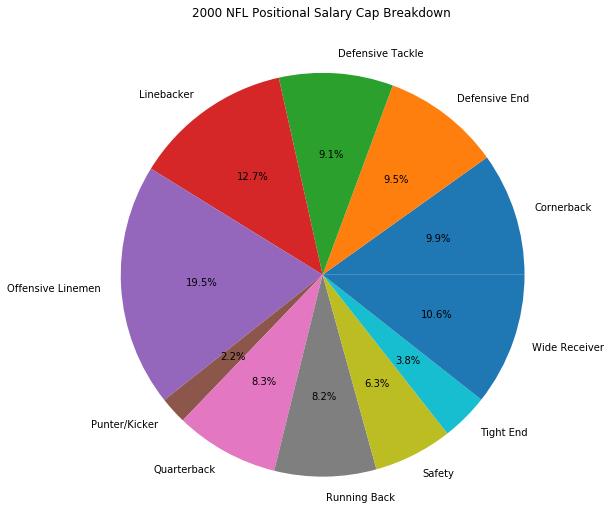

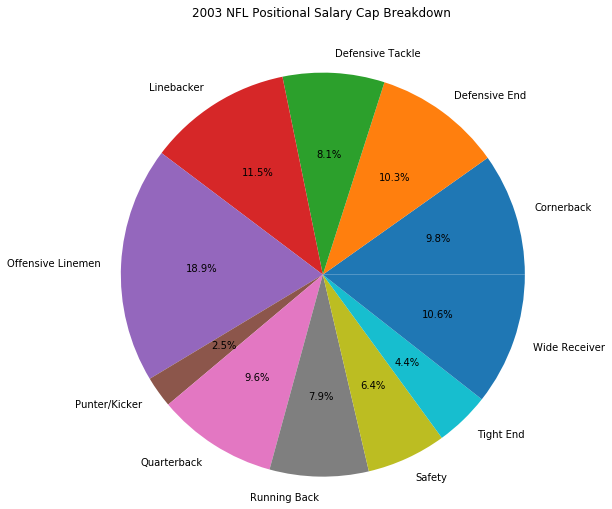

In [183]:
# We convert the dictionaries to ordered dictionaries so our pie charts are easier to compare
od_2000 = collections.OrderedDict(sorted(salaries_2000[2].items()))

positions_2000 = list(od_2000.keys())
capSums_2000 = list(od_2000.values())

# Replace "Outside Linebacker" with "Offensive Linemen"
positions_2000_amended = ["Offensive Linemen" if x=="Outside Linebacker" else x for x in positions_2000]

# Plot
plt.pie(capSums_2000, labels=positions_2000_amended, shadow=False, autopct='%1.1f%%', startangle=0)
 
plt.axis('equal')
plt.title('2000 NFL Positional Salary Cap Breakdown', y = 1.08)
fig = plt.gcf()
fig.set_size_inches(8,8)

plt.show()

### 2003 stuff now
od_2003 = collections.OrderedDict(sorted(salaries_2003[2].items()))

positions_2003 = list(od_2003.keys())
capSums_2003 = list(od_2003.values())

positions_2003_amended = ["Offensive Linemen" if x=="Outside Linebacker" else x for x in positions_2003]

# Plot
plt.pie(capSums_2003, labels=positions_2003_amended, autopct='%1.1f%%', startangle=0)
 
plt.axis('equal')

plt.title('2003 NFL Positional Salary Cap Breakdown', y = 1.08)
fig = plt.gcf()
fig.set_size_inches(8,8) 

plt.show()

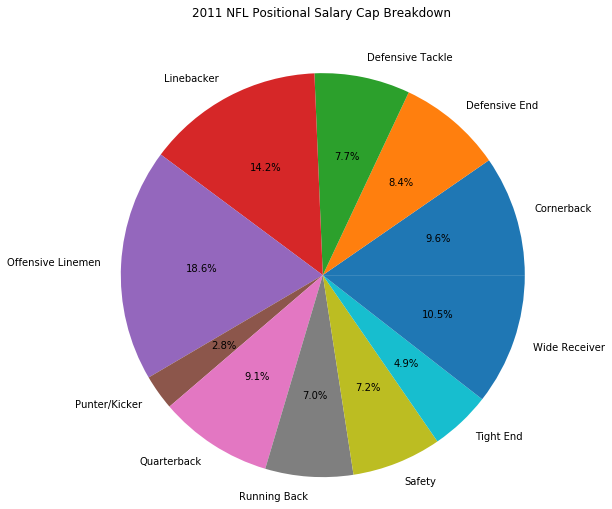

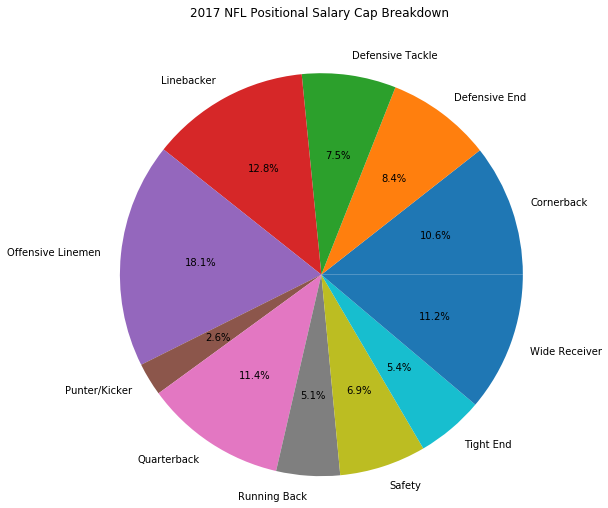

In [190]:
salaries_2011_removed = dict(salaries_2011[2])

# show up as 0%, remove the clutter
del salaries_2011_removed['COA']
del salaries_2011_removed['KR']

salary_breakdown_2011 = convertSpotrac2USAT(salaries_2011_removed)

# We convert the dictionaries to ordered dictionaries so our pie charts are easier to compare
od_2011 = collections.OrderedDict(sorted(salary_breakdown_2011.items()))

positions_2011_a = list(od_2011.keys())
capSums_2011_a = list(od_2011.values())

# Plot
plt.pie(capSums_2011_a, labels = positions_2011_a, autopct='%1.1f%%', shadow=False)
plt.axis('equal')

plt.title('2011 NFL Positional Salary Cap Breakdown', y = 1.08)
fig = plt.gcf()
fig.set_size_inches(8,8) 

plt.show()

salary_breakdown_2017 = convertSpotrac2USAT(salaries_2017[2])

# We convert the dictionaries to ordered dictionaries so our pie charts are easier to compare
od_2017 = collections.OrderedDict(sorted(salary_breakdown_2017.items()))

positions_2017_a = list(od_2017.keys())
capSums_2017_a = list(od_2017.values())

# Plot
plt.pie(capSums_2017_a, labels = positions_2017_a, autopct='%1.1f%%', shadow=False)
plt.axis('equal')

plt.title('2017 NFL Positional Salary Cap Breakdown', y = 1.08)
fig = plt.gcf()
fig.set_size_inches(8,8) 

plt.show()

## Comparing 2011 and 2017

With Spotrac data, we can get much more granular with positions. This is useful since outside linebackers / inside linebackers will often play very different roles (and get paid such), and clumping them together as linebacker removes our information regarding their values. Similarly, tackles, guards, and centers may be valued differently.

Thus we compare the two furthest apart years available in Spotrac data: 2011 and 2017.

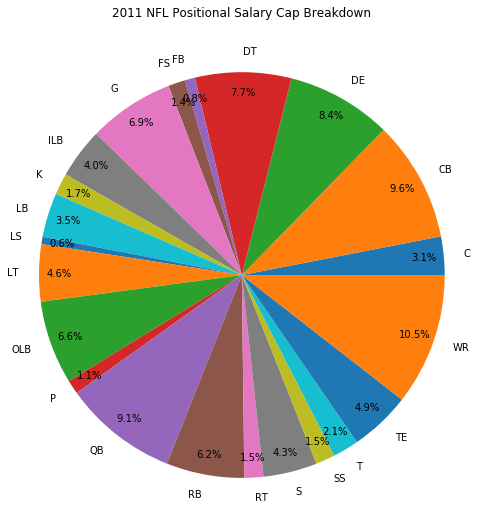

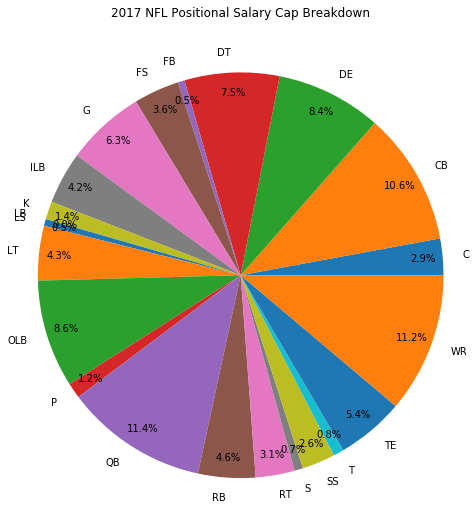

In [246]:
salaries_2011_removed = dict(salaries_2011[2])

# show up as 0%, remove the clutter
del salaries_2011_removed['COA']
del salaries_2011_removed['KR']

od_2011 = collections.OrderedDict(sorted(salaries_2011_removed.items()))

positions_2011 = list(od_2011.keys())
capSums_2011 = list(od_2011.values())

# Plot
plt.pie(capSums_2011, labels = positions_2011, autopct='%1.1f%%', pctdistance=0.9, labeldistance = 1.1)
plt.axis('equal')

plt.title('2011 NFL Positional Salary Cap Breakdown', y = 1.08)
fig = plt.gcf()
fig.set_size_inches(8, 8) 

plt.show()

## 2017

od_2017 = collections.OrderedDict(sorted(salaries_2017[2].items()))

positions_2017 = list(od_2017.keys())
capSums_2017 = list(od_2017.values())

# Plot
plt.pie(capSums_2017, labels = positions_2017, autopct='%1.1f%%', pctdistance=0.9, labeldistance = 1.1)
plt.axis('equal')

plt.title('2017 NFL Positional Salary Cap Breakdown', y = 1.08)
fig = plt.gcf()
fig.set_size_inches(8, 8) 

plt.show()

In [241]:
de_2017 = salaries_2017[1]['DE']
np.mean(de_2017)
#stats.percentileofscore(de_2017, 1000000)

1487986.0238095238